## Import modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


## Reading dataset

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

### Dataset description

client_id - идентификатор клиента  
education - уровень образования  
sex - пол заемщика  
age - возраст заемщика  
car - флаг наличия автомобиля  
car_type - флаг автомобиля иномарки  
decline_app_cnt - количество отказанных прошлых заявок  
good_work - флаг наличия “хорошей” работы  
bki_request_cnt - количество запросов в БКИ  
home_address - категоризатор домашнего адреса  
work_address - категоризатор рабочего адреса  
income - доход заемщика  
foreign_passport - наличие загранпаспорта  
sna - связь заемщика с клиентами банка  
first_time - давность наличия информации о заемщике  
score_bki - скоринговый балл по данным из БКИ  
region_rating - рейтинг региона  
app_date - дата подачи заявки  
default - флаг дефолта по кредиту

In [3]:
df_train['sample'] = 1
df_test['sample'] = 0
df_test['default'] = 0
data = df_test.append(df_train, sort=False).reset_index(drop=True)

In [4]:
data[data['sample'] == 1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73799 entries, 36349 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  i

In [5]:
# Unique data by columns

data[data['sample'] == 1].nunique()

client_id           73799
app_date              120
education               5
sex                     2
age                    52
car                     2
car_type                2
decline_app_cnt        21
good_work               2
score_bki           69096
bki_request_cnt        38
region_rating           7
home_address            3
work_address            3
income                966
sna                     4
first_time              4
foreign_passport        2
sample                  1
default                 2
dtype: int64

In [6]:
# Empty cells by columns

data[data['sample'] == 1].isna().sum()

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

In [7]:
# Main metrics of dataset

data[data['sample'] == 1].describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,sample,default
count,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.0,73799.000000
mean,55137.965094,39.280641,0.275749,0.164894,-1.904724,2.000339,56.725701,1.575509,2.496280,41099.775417,1.733330,2.765458,1.0,0.126994
std,31841.921168,11.520378,0.804272,0.371087,0.498231,2.252073,13.055717,0.527631,0.689818,46166.322400,1.123622,1.009463,0.0,0.332968
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,1.0,0.000000
25%,27440.500000,30.000000,0.000000,0.000000,-2.259534,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,1.0,0.000000
50%,55274.000000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,1.0,0.000000
75%,82758.500000,48.000000,0.000000,0.000000,-1.569831,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,1.0,0.000000
max,110147.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.0,1.000000


In [8]:
data.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
468,21274,28JAN2014,SCH,F,62,N,N,0,0,-3.029282,0,40,2,3,7000,4,2,N,0,0
22361,6690,14JAN2014,UGR,F,41,Y,N,0,1,-0.870397,4,60,2,3,30000,1,3,N,0,0
62468,2419,08JAN2014,GRD,M,49,Y,Y,0,0,-1.955251,1,40,1,1,80000,1,3,Y,1,0
64088,53036,01MAR2014,SCH,F,51,N,N,0,0,-1.185729,2,60,2,3,20000,1,3,N,1,0
84983,98275,15APR2014,GRD,M,40,Y,Y,0,0,-0.931182,2,40,2,3,250000,4,2,N,1,1


## Function list

In [9]:
def outliers(col, col_name):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    outliers_count = pd.DataFrame(col[((col < (Q1 - 1.5 * IQR)) | (col > (Q3 + 1.5 * IQR)))]).count()
    print(f'In column {outliers_count.index[0]} {outliers_count[0]} ouliers')


def percent_of_target(col1, col2):
    display(pd.crosstab(col1, col2, normalize='index'))

### Setup

In [40]:
num_cols = ['age', 'score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income']
cat_cols = ['education', 'first_time', 'sna', 'work_address', 'home_address', 'region_rating']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
le = LabelEncoder()

### Numerical columns

#### Age

This column doen't have NaN. So, let's look at outliers and distribution by Default.

In [11]:
outliers(data[data['sample'] == 1]['age'], 'age')

In column age 0 ouliers


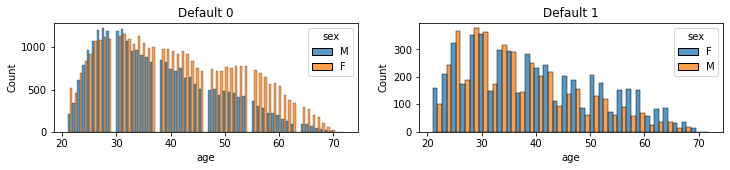

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.histplot(data=data[(data['sample'] == 1) & (data['default'] == 0)], 
             x='age', hue='sex', multiple='dodge', ax=ax[0]).set_title('Default 0')
sns.histplot(data=data[(data['sample'] == 1) & (data['default'] == 1)], 
             x='age', hue='sex', multiple='dodge', ax=ax[1]).set_title('Default 1')
plt.show()

Intresting. Kredit for women more ofter had been approved. Denied the same.

In [13]:
print(f'Min Age is {data[data["sample"] == 1]["age"].min()}')
print(f'Max Age is {data[data["sample"] == 1]["age"].max()}')

Min Age is 21
Max Age is 72


Split it on categories by 5 years

In [14]:
cut_bins = list([x for x in range(19, 80, 5)])
cut_labels = list([x for x in range(len(cut_bins)-1)])
data['cat_age'] = pd.cut(data['age'], bins=cut_bins, labels=cut_labels)

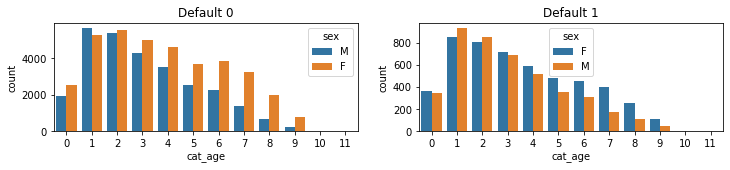

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.countplot(data=data[(data['sample'] == 1) & (data['default'] == 0)], 
              x='cat_age', hue='sex', ax=ax[0]).set_title('Default 0')
sns.countplot(data=data[(data['sample'] == 1) & (data['default'] == 1)], 
              x='cat_age', hue='sex', ax=ax[1]).set_title('Default 1')
plt.show()

In [16]:
percent_of_target(data[data['sample'] == 1]['cat_age'], data[data['sample'] == 1]['default'])

default,0,1
cat_age,,
0,0.862229,0.137771
1,0.859879,0.140121
2,0.868963,0.131037
3,0.868765,0.131235
4,0.880069,0.119931
5,0.881624,0.118376
6,0.888581,0.111419
7,0.889210,0.110790
8,0.876908,0.123092


About equal distribution by categories over Default column.

#### score_bki

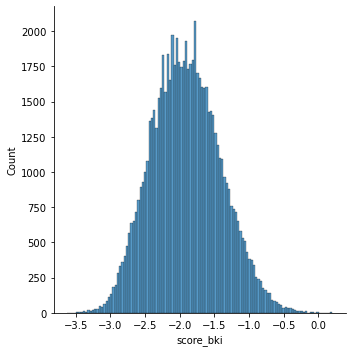

In [17]:
sns.displot(data[data['sample'] == 1]['score_bki'])
plt.show()

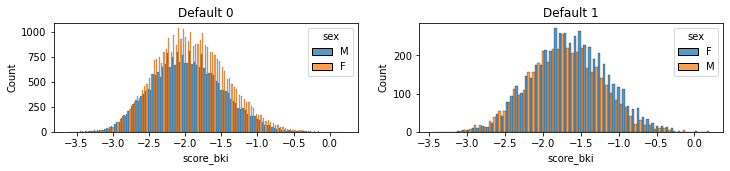

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.histplot(data=data[(data['sample'] == 1) & (data['default'] == 0)], 
             x='score_bki', hue='sex', multiple='dodge', ax=ax[0]).set_title('Default 0')
sns.histplot(data=data[(data['sample'] == 1) & (data['default'] == 1)], 
             x='score_bki', hue='sex', multiple='dodge', ax=ax[1]).set_title('Default 1')
plt.show()

This column doen't have NaN. So, let's look at outliers and distribution by Default

In [19]:
outliers(data[data['sample'] == 1]['score_bki'], 'score_bki')

In column score_bki 351 ouliers


Let's make column to mark outliers.

In [20]:
Q1 = data[data['sample'] == 1]['score_bki'].quantile(0.25)
Q3 = data[data['sample'] == 1]['score_bki'].quantile(0.75)
IQR = Q3 - Q1
data['score_bki_outliers'] = ((data['sample'] == 1) & ((data['score_bki'] < (Q1 - 1.5 * IQR)) | (data['score_bki'] > (Q3 + 1.5 * IQR)))).astype('int32')

#### decline_app_cnt

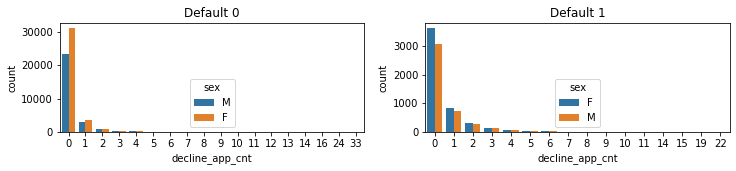

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.countplot(data=data[(data['sample'] == 1) & (data['default'] == 0)], 
              x='decline_app_cnt', hue='sex', ax=ax[0]).set_title('Default 0')
sns.countplot(data=data[(data['sample'] == 1) & (data['default'] == 1)], 
              x='decline_app_cnt', hue='sex', ax=ax[1]).set_title('Default 1')
plt.show()

Count sum of each group

In [22]:
data[data['sample'] == 1]['decline_app_cnt'].value_counts()

0     61214
1      8397
2      2468
3       903
4       414
5       165
6       113
7        48
9        24
8        19
10       11
11        9
13        3
12        2
14        2
16        2
15        1
19        1
22        1
24        1
33        1
Name: decline_app_cnt, dtype: int64

Let's group tails. Leave only 5 groups.

In [23]:
mask = (data['decline_app_cnt'] > 4)
data.loc[mask, 'decline_app_cnt'] = 4

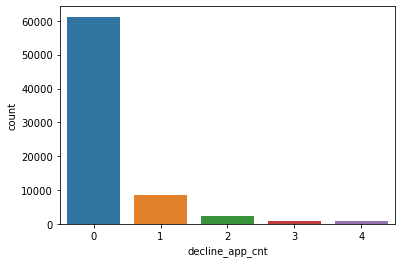

In [24]:
sns.countplot(x='decline_app_cnt', data=data[data['sample'] == 1])
plt.show()

In [25]:
percent_of_target(data[data['sample'] == 1]['decline_app_cnt'], data[data['sample'] == 1]['default'])

default,0,1
decline_app_cnt,,
0,0.890466,0.109534
1,0.812195,0.187805
2,0.756483,0.243517
3,0.726467,0.273533
4,0.703794,0.296206


#### bki_request_cnt

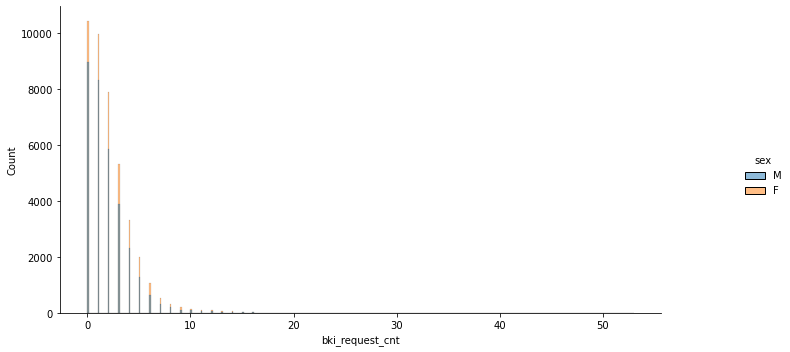

In [26]:
pl = sns.displot(x='bki_request_cnt', data=data[data['sample'] == 1], hue='sex')
pl.fig.set_figwidth(12)
pl.fig.set_figheight(5)

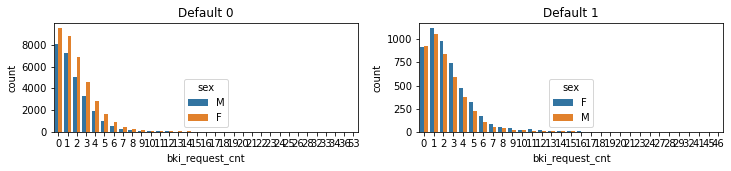

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.countplot(data=data[(data['sample'] == 1) & (data['default'] == 0)], 
              x='bki_request_cnt', hue='sex', ax=ax[0]).set_title('Default 0')
sns.countplot(data=data[(data['sample'] == 1) & (data['default'] == 1)], 
              x='bki_request_cnt', hue='sex', ax=ax[1]).set_title('Default 1')
plt.show()

In [28]:
data[data['sample'] == 1]['bki_request_cnt'].value_counts()

0     19381
1     18276
2     13749
3      9187
4      5627
5      3268
6      1704
7       852
8       508
9       299
10      225
11      188
12      144
13       94
14       86
15       54
16       35
18       22
17       19
19       18
21       12
24       11
20        9
23        7
22        4
28        4
25        2
26        2
27        2
32        2
41        1
46        1
45        1
29        1
36        1
34        1
33        1
53        1
Name: bki_request_cnt, dtype: int64

In [29]:
mask1 = (data['bki_request_cnt'] > 18)
mask2 = (data['bki_request_cnt'].between(15, 18, inclusive=True))
mask3 = (data['bki_request_cnt'].between(12, 14, inclusive=True))
mask4 = (data['bki_request_cnt'].between(9, 11, inclusive=True))
mask5 = (data['bki_request_cnt'].between(6, 8, inclusive=True))
mask6 = (data['bki_request_cnt'].between(4, 5, inclusive=True))

data.loc[mask6, 'bki_request_cnt'] = 4
data.loc[mask5, 'bki_request_cnt'] = 5
data.loc[mask4, 'bki_request_cnt'] = 6
data.loc[mask3, 'bki_request_cnt'] = 7
data.loc[mask2, 'bki_request_cnt'] = 8
data.loc[mask1, 'bki_request_cnt'] = 9

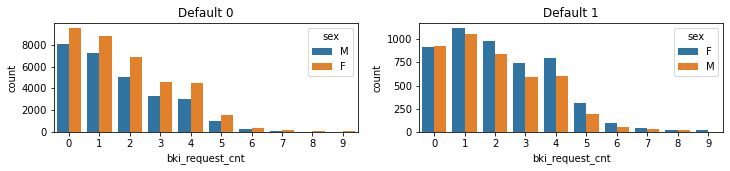

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
sns.countplot(data=data[(data['sample'] == 1) & (data['default'] == 0)], 
              x='bki_request_cnt', hue='sex', ax=ax[0]).set_title('Default 0')
sns.countplot(data=data[(data['sample'] == 1) & (data['default'] == 1)], 
              x='bki_request_cnt', hue='sex', ax=ax[1]).set_title('Default 1')
plt.show()

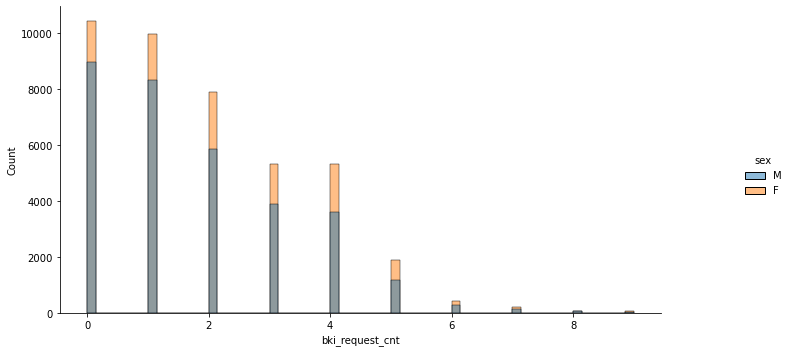

In [31]:
pl = sns.displot(x='bki_request_cnt', data=data[data['sample'] == 1], hue='sex')
pl.fig.set_figwidth(12)
pl.fig.set_figheight(5)

#### Income

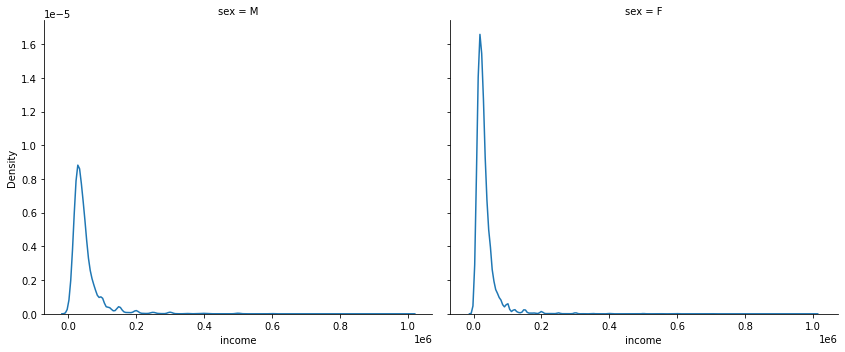

In [32]:
pl = sns.displot(data = data[data['sample'] == 1], x='income', col='sex', kind='kde')
pl.fig.set_figwidth(12)
pl.fig.set_figheight(5)

In [33]:
outliers(data[data['sample'] == 1]['income'], 'income')

In column income 4695 ouliers


In [34]:
Q1 = data[data['sample'] == 1]['income'].quantile(0.25)
Q3 = data[data['sample'] == 1]['income'].quantile(0.75)
IQR = Q3 - Q1
data['income_outliers'] = ((data['sample'] == 1) & ((data['income'] < (Q1 - 1.5 * IQR)) | (data['income'] > (Q3 + 1.5 * IQR)))).astype('int32')

In [35]:
data['income'] = np.log(data['income'] + 1)

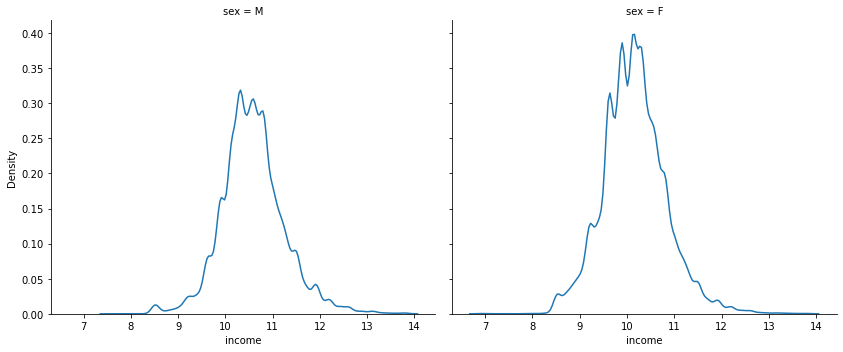

In [36]:
pl = sns.displot(data = data[data['sample'] == 1], x='income', col='sex', kind='kde')
pl.fig.set_figwidth(12)
pl.fig.set_figheight(5)

### Binar columns

#### sex

Convert from literal to numeric.

In [41]:
data['sex'] = le.fit_transform(data['sex'])

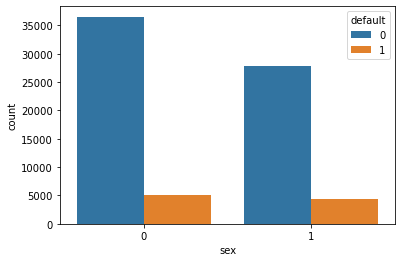

In [52]:
sns.countplot(data=data[(data['sample'] == 1)], x='sex', hue='default')
plt.show()

#### car

Convert from literal to numeric

In [53]:
data['car'] = le.fit_transform(data['car'])

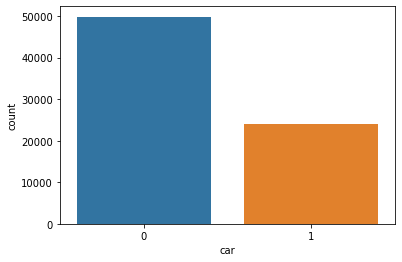

In [56]:
sns.countplot(data=data[(data['sample'] == 1)], x='car')
plt.show()

In [ ]:
sns.set(font_scale=1)
plt.subplots(figsize=(12, 12))
sns.heatmap(data[data['sample'] == 1].corr(), square=True,
              annot=True, fmt=".3f", linewidths=0.1, cmap="RdBu")
plt.show()